In [475]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
import qutip as qt

plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=200, formatter={'float': '{:.5f}'.format})

<Figure size 640x480 with 0 Axes>

In [392]:
fF = 1e-15
nH = 1e-9
C_val = 2
L_val = 2

In [499]:
def resonator_C_resonator(Cc, C_val=C_val, L_val=L_val):
    Cc = sq.Capacitor(Cc, 'fF')
    C = sq.Capacitor(C_val,   'fF')
    L = sq.Inductor (L_val,   'nH')
    elements = {(0, 1): [L, C],
                (0, 2): [L, C],
                (1, 2): [Cc], }
    return sq.Circuit(elements)

def resonator_resonator(connected=True):
    C = sq.Capacitor(C_val, 'fF')
    L = sq.Inductor (L_val,  'nH')
    if connected:
        elements = {(0, 1): [L, C, L, C], }
    else:
        elements = {(0, 1): [L, C],
                    (0, 2): [L, C], }
    return sq.Circuit(elements)

def resonator_resonator_eq(connected=True):
    if connected:
        C = sq.Capacitor(C_val+C_val, 'fF')
        L = sq.Inductor ((1/L_val+1/L_val)**-1, 'nH')
        elements = {(0, 1): [L, C], }
    else:
        C = sq.Capacitor(C_val, 'fF')
        L = sq.Inductor (L_val,  'nH')
        elements = {(0, 1): [L, C],
                    (0, 2): [L, C], }
    return sq.Circuit(elements)

def resonator(Cc):
    # CC = sq.Capacitor(Cc, 'fF')
    # C = sq.Capacitor(C_val, 'fF')
    # L = sq.Inductor(L_val,  'nH')
    # elements = {(0, 2): [L],
    #             (0, 1): [C],
    #             (1, 2): [CC]}
    # return sq.Circuit(elements)
    
    if Cc == 0:
        C = sq.Capacitor(C_val, 'fF')
        L = sq.Inductor(L_val,  'nH')
        elements = {(0, 1): [L, C], }
        return sq.Circuit(elements)
    else:
        C = sq.Capacitor(1/(1/C_val+1/Cc), 'fF')
        L = sq.Inductor (L_val, 'nH')
        elements = {(0, 1): [L, C], }
    return sq.Circuit(elements)
    
def shutned_resonator(Cc):
    Cc = sq.Capacitor(Cc, 'fF')
    C = sq.Capacitor(C_val,   'fF')
    L = sq.Inductor (L_val,   'nH')
    elements = {(0, 1): [L, C, Cc], }
    return sq.Circuit(elements)

In [500]:
n_eig = 8
trunc_num = 60
Cc = 1

In [507]:
coupled_res = resonator_C_resonator(Cc=Cc)
res = resonator(Cc=Cc)

uncoupled_res = resonator_C_resonator(Cc=0)
res_0 = resonator(Cc=0)

uncoupled_renormalized_res = resonator_C_resonator(Cc=0, C_val=(1/C_val+1/Cc)**-1, L_val=L_val)
renormalized_res = resonator(Cc=Cc)

coupled_res.set_trunc_nums([trunc_num, trunc_num])
uncoupled_res.set_trunc_nums([trunc_num, trunc_num])
uncoupled_renormalized_res.set_trunc_nums([trunc_num, trunc_num])
res.set_trunc_nums([trunc_num  ])
res_0.set_trunc_nums([trunc_num])
renormalized_res.set_trunc_nums([trunc_num])

_ = coupled_res.diag(n_eig)
_ = uncoupled_res.diag(n_eig)
_ = uncoupled_renormalized_res.diag(n_eig)
_ = res.diag(n_eig)
_ = res_0.diag(n_eig)
_ = renormalized_res.diag(n_eig)

In [503]:
Q_0 = res_0._charge_op_isolated(0)
Φ_0 = res_0._flux_op_isolated(0)

Q = res._charge_op_isolated(0)
Φ = res._flux_op_isolated(0)

In [504]:
# H_res_0 = 1 / 2 * (1/fF)               * Q_0 ** 2  + 1 / 2 * (1/nH) * Φ_0 ** 2
# H_res   = 1 / 2 * (1/fF) * (1 + 1/Cc)  * Q ** 2    + 1 / 2 * (1/nH) * Φ   ** 2# 
H_res_0 = res_0.hamiltonian()
H_res   = res.hamiltonian()

I = qt.identity(H_res.shape[0])

H_unc_res = qt.tensor(H_res_0, I) + qt.tensor(I, H_res_0)

H_unc_renorm = qt.tensor(H_res, I) + qt.tensor(I, H_res)

H_coup_res = qt.tensor(H_res, I) + qt.tensor(I, H_res) - (1 / (Cc*fF)) * qt.tensor(Q, Q)

In [490]:
diag_H = np.real(np.diag(H_coup_res)/2/np.pi/1e9)[1:]
diag_H

array([112.53954, 225.07908, 337.61862, ..., 13054.58658, 13167.12612, 13279.66566])

In [491]:
diag_H_full = np.real(np.diag(coupled_res.hamiltonian())/2/np.pi/1e9)[1:]
diag_H_full

array([45.94407, 91.88815, 137.83222, ..., 7313.88307, 7359.82715, 7405.77122])

C:\Users\gabri\AppData\Local\Temp\ipykernel_22224\3983765610.py:3: UserWarning: Matplotlib is currently using QtAgg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


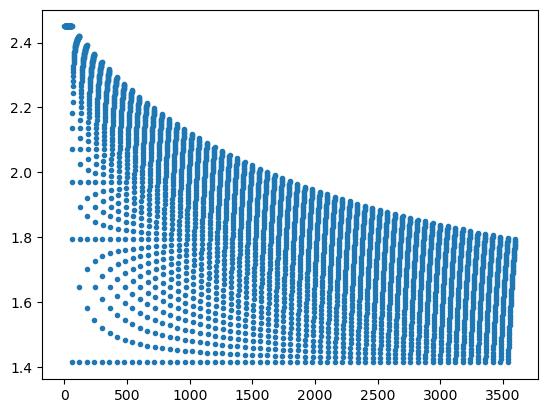

In [497]:
fig, ax = plt.subplots()
ax.plot(diag_H/diag_H_full, '.')
fig.show()

In [493]:
E_0 = sq_ext.diag(H_coup_res,n_eig=n_eig, out='GHz')[0]
E_0 - E_0[0]

array([0.00000, 79.57747, 137.83222, 159.15494, 217.40970, 238.73241, 275.66445, 296.98717])

In [494]:
coupled_res.efreqs

array([0.00000, 45.94407, 79.57747, 91.88815, 125.52155, 137.83222, 159.15494, 171.46562])

In [495]:
(E_0 - E_0[0]) / coupled_res.efreqs


array([0.00000, 1.73205, 1.73205, 1.73205, 1.73205, 1.73205, 1.73205, 1.73205])

In [406]:
(E_0 - E_0[0]) / coupled_res.efreqs


array([-0.000000000000, 1.414213562370, 1.999999999996, 1.581138830084, 1.757359312877, 1.618033988749])

In [198]:
(E_0 - E_0[0]) / np.sqrt(3)


array([0.000000000000, 91.888149236969, 159.154943091898, 183.776298473935, 251.043092328866, 275.664447710905])

In [505]:
E_0 = sq_ext.diag(H_unc_renorm,n_eig=n_eig, out='GHz')[0]
E_0 - E_0[0]

array([0.00000, 112.53954, 112.53954, 225.07908, 225.07908, 225.07908, 337.61862, 337.61862])

In [509]:
uncoupled_renormalized_res.efreqs

array([-0.00000, 112.53954, 112.53954, 225.07908, 225.07908, 225.07908, 337.61862, 337.61862])